In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from shapely.geometry import Point
import os
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [2]:
BASE_DIR = os.getenv("BASE_DIR")
if not BASE_DIR:
  raise ValueError("BASE_DIR environment variable is not set.")

### Counting data
Get total audio length

In [4]:
# List of countries
countries = ["australia", "kenya", "maldives", "mexico", "indonesia"]

data_dir_template = os.path.join(BASE_DIR, "marrs_acoustics/data/output_dir_{}/raw_file_list.csv")
output_csv_path = os.path.join(BASE_DIR, "marrs_acoustics/data/results/extra_outputs/recording_times_table.csv")

# Initialise totals
total_files = 0
total_time_minutes = 0

# Function to convert minutes into months, days, hours, and minutes
def format_time(minutes: int) -> str:
    days, hours = divmod(minutes, 60 * 24)
    months, days = divmod(days, 30)
    hours, minutes = divmod(hours, 60)
    return f"{months} months, {days} days, {hours} hours, {minutes} minutes"

# To store site data
site_data = []

# Iterate through each country
for country in countries:
    country_csv_path = data_dir_template.format(country)

    # Load the CSV file
    try:
        df = pd.read_csv(country_csv_path)

        # Extract site and date information
        df["site"] = df["filename"].str[:6]
        df["date"] = pd.to_datetime(df["filename"].str[7:15], format="%Y%m%d")

        # Exclude dates before 2020
        df = df[df["date"] >= "2020-01-01"]

        for site, group in df.groupby("site"):
            start_date = group["date"].min()
            end_date = group["date"].max()
            total_days = (end_date - start_date).days + 1
            site_data.append({"site": site, "start_date": start_date, "end_date": end_date, "total_days": total_days})

        num_files = len(df)
        total_time = num_files  # Each file = 1 minute

        print(f"{country.title()}: {num_files} files, {format_time(total_time)}")

        # Update totals
        total_files += num_files
        total_time_minutes += total_time
    except FileNotFoundError:
        print(f"File for {country.title()} not found at {country_csv_path}")

# Create a DataFrame for site data
site_df = pd.DataFrame(site_data)

# Save site data to CSV
site_df.to_csv(output_csv_path, index=False)

# Print mean and standard deviation of total days
mean_days = site_df["total_days"].mean()
std_days = site_df["total_days"].std()
print(f"\nMean total days for each site across all projects: {mean_days:.2f}, Standard deviation: {std_days:.2f}")

# Print combined totals
print(f"\nCombined Total: {total_files} files, {format_time(total_time_minutes)}")


Australia: 97218 files, 2 months, 7 days, 12 hours, 18 minutes
Kenya: 42792 files, 0 months, 29 days, 17 hours, 12 minutes
Maldives: 58525 files, 1 months, 10 days, 15 hours, 25 minutes
Mexico: 86066 files, 1 months, 29 days, 18 hours, 26 minutes
Indonesia: 267776 files, 6 months, 5 days, 22 hours, 56 minutes

Mean total days for each site across all projects: 27.85, Standard deviation: 10.11

Combined Total: 552377 files, 12 months, 23 days, 14 hours, 17 minutes


### Count detections

In [5]:
# Threshold for logit column
THRESHOLD = 1.0

# Directory pattern for inference files
agile_outputs_dir_template = os.path.join(BASE_DIR, "marrs_acoustics/data/output_dir_{}/agile_outputs")

# Initialise total counts
total_counts_per_country = {}

total_count_all_countries = 0

# Iterate through each country
for country in countries:
    country_dir = agile_outputs_dir_template.format(country)
    country_total = 0

    # Walk through the agile_outputs directory
    for root, dirs, files in os.walk(country_dir):
        for file in files:
            if file.endswith("_inference.csv"):
                file_path = os.path.join(root, file)

                # Read the inference CSV file
                df = pd.read_csv(file_path)

                # Count rows where logit >= THRESHOLD
                count = df[df[" logit"] >= THRESHOLD].shape[0]

                country_total += count

    total_counts_per_country[country] = country_total
    total_count_all_countries += country_total

    print(f"{country.title()}: {country_total} rows with logit >= {THRESHOLD}")

# Print total across all countries
print(f"\nTotal across all countries: {total_count_all_countries} rows with logit >= {THRESHOLD}")


Australia: 84188 rows with logit >= 1.0
Kenya: 98843 rows with logit >= 1.0
Maldives: 108614 rows with logit >= 1.0
Mexico: 46767 rows with logit >= 1.0
Indonesia: 577541 rows with logit >= 1.0

Total across all countries: 915953 rows with logit >= 1.0


### World map

/tmp/ipykernel_14292/3735193580.py:35: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf['Datasets'] == 2].plot(ax=ax, color='black', marker='o', markersize=marker_size_on_plot,


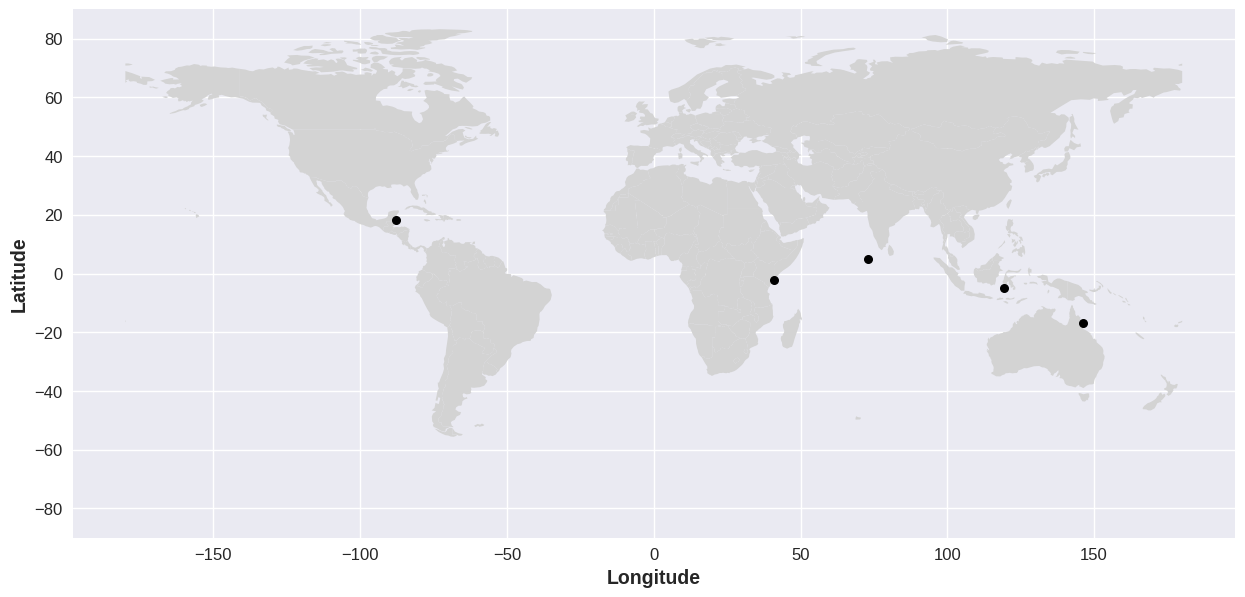

In [6]:
# Data preparation
data = {
    'Location': ['Australia', 'Indonesia', 'Kenya', 'Maldives', 'Mexico'],
    'Latitude': [-16.84781, -4.93154, -2.21474, 4.8864, 18.333292],
    'Longitude': [146.22798, 119.31577,  41.01613, 72.9278, -87.808362],
    'Datasets': [1, 1, 1, 1, 1]
}

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    data, 
    geometry=[Point(xy) for xy in zip(data['Longitude'], data['Latitude'])]
)

# World basemap
base_map_path = os.path.join(BASE_DIR, "marrs_acoustics/code/scratch/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
world = gpd.read_file(base_map_path)

# Clipping the world map to the specified latitude range
world_clipped = world.cx[:, -60:60]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_clipped.plot(ax=ax, color='lightgrey')

# Set the y-limits (latitude) of the map to -50 to 50
ax.set_ylim(-90, 90)

# Adjust marker size for the plot here
marker_size_on_plot = 30

# Plotting points with thicker black outlines
gdf[gdf['Datasets'] == 1].plot(ax=ax, color='black', marker='o', markersize=marker_size_on_plot, 
                               label='1 Dataset', edgecolor='black', linewidth=1)
gdf[gdf['Datasets'] == 2].plot(ax=ax, color='black', marker='o', markersize=marker_size_on_plot, 
                               label='2 Datasets', edgecolor='black', linewidth=1)

# Title and labels
plt.xlabel('Longitude', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.ylabel('Latitude', fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)

# Show plot
plt.show()



## Box plot functions globally


In [7]:
# The map plot above breaks the ability to display, this is a quick fix
%matplotlib inline

/tmp/ipykernel_14292/2588537169.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_14292/2588537169.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([TREATMENT_LABELS[t] for t in TREATMENT_ORDER])


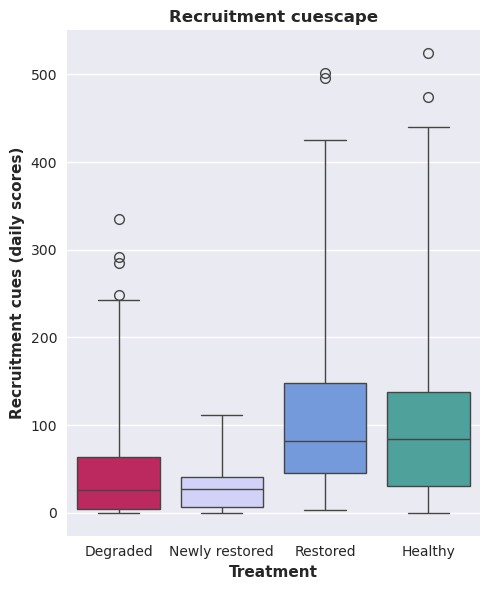

/tmp/ipykernel_14292/2588537169.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_14292/2588537169.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([TREATMENT_LABELS[t] for t in TREATMENT_ORDER])


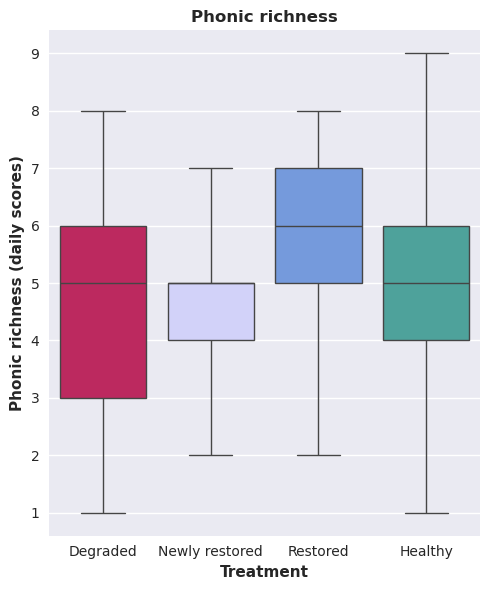

/tmp/ipykernel_14292/2588537169.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_14292/2588537169.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([TREATMENT_LABELS[t] for t in TREATMENT_ORDER])


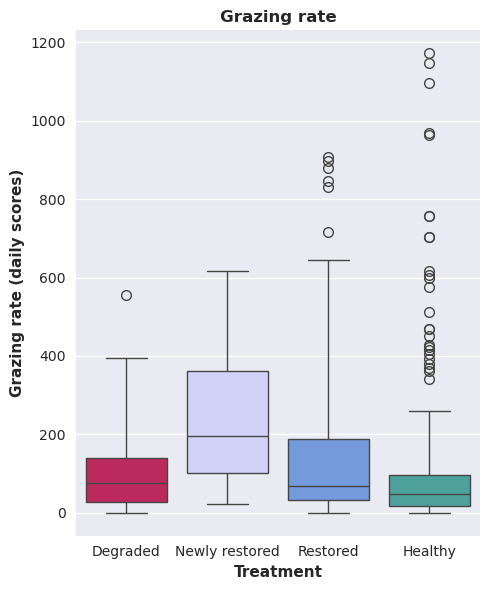

/tmp/ipykernel_14292/2588537169.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_14292/2588537169.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([TREATMENT_LABELS[t] for t in TREATMENT_ORDER])


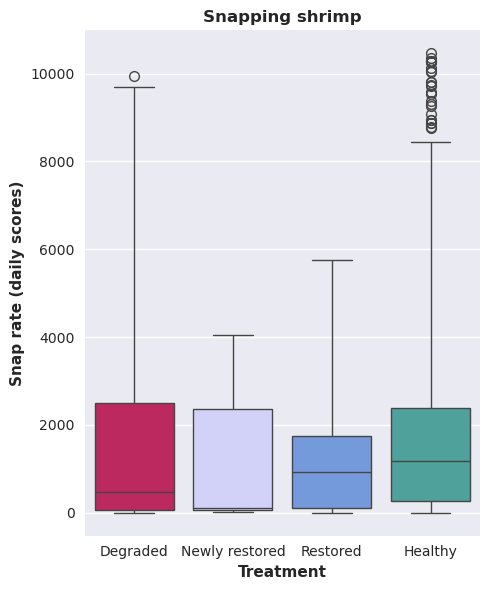

In [ ]:
import os
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Get path to folder of csv files
BASE_DIR = os.getenv("BASE_DIR")
if not BASE_DIR:
  raise ValueError("BASE_DIR environment variable is not set.")
csv_dir = os.path.join(BASE_DIR, "marrs_acoustics/data/results/functions")

# Combine treatment order, label, and color in a single dict
TREATMENT_INFO = {
  "degraded": {
      "label": "Degraded",
      "color": "#D41159"
  },
  "newly_restored": {
      "label": "Newly restored",
      "color": "#CCCCFF"
  },
  "restored": {
      "label": "Restored",
      "color": "#6495ED"
  },
  "healthy": {
      "label": "Healthy",
      "color": "#40B0A6"
  }
}

# Extract a list (order) of treatment keys
TREATMENT_ORDER = list(TREATMENT_INFO.keys())

# Build separate dictionaries for labels & colours for Seaborn
TREATMENT_LABELS = {k: v["label"] for k, v in TREATMENT_INFO.items()}
TREATMENT_COLORS = {k: v["color"] for k, v in TREATMENT_INFO.items()}

# CSVs mapping: filename -> config
CSV_MAPPING = {
    "settlement_cuescape.csv": {
        "title": "Recruitment cuescape",
        "exclude_outliers": 6,
        "y-axis title": "Recruitment cues (daily scores)"
    },
    "phonic_richness.csv": {
        "title": "Phonic richness",
        "exclude_outliers": 0,
        "y-axis title": "Phonic richness (daily scores)"
    },
    "graze_count.csv": {
        "title": "Parrot fish grazing rate",
        "exclude_outliers": 10,
        "y-axis title": "Parrot fish grazing rate (daily scores)"
    },
    "snaps_count.csv": {
        "title": "Snapping shrimp",
        "exclude_outliers": 10,
        "y-axis title": "Snap rate (daily scores)"
    }
}

def read_data(csv_path: str) -> pd.DataFrame:
  """Read CSV and set 'treatment' as an ordered categorical."""
  df = pd.read_csv(csv_path)
  df["treatment"] = pd.Categorical(
    df["treatment"],
    categories=TREATMENT_ORDER,
    ordered=True
  )
  return df

def plot_box(
    df: pd.DataFrame,
    x_col: str,
    y_col: str,
    plot_title: str,
    y_axis_label: str,
    exclude_outliers: int = 0,
    fig_width: float = 6,
    fig_height: float = 4,
    whis: float = 1.5
) -> plt.Figure:
  """
  Plot a boxplot of y_col by x_col, optionally excluding
  the top-end outliers. 'whis' controls how far the whiskers extend
  past the quartiles, thus affecting outlier detection (larger = fewer outliers).
  """
  # Exclude top 'exclude_outliers' rows based on y_col
  if exclude_outliers > 0:
    df = df.drop(df.nlargest(exclude_outliers, y_col).index)

  sns.set_style("darkgrid")
  fig, ax = plt.subplots(figsize=(fig_width, fig_height))

  sns.boxplot(
      data=df,
      x=x_col,
      y=y_col,
      order=TREATMENT_ORDER,
      palette=TREATMENT_COLORS,
      whis=3, # How forgiving is the main body to keeping outliers
      ax=ax
  )

  # Label x-axis ticks using our unified labels
  ax.set_xticklabels([TREATMENT_LABELS[t] for t in TREATMENT_ORDER])
  ax.set_xlabel("Treatment", fontweight="bold")
  ax.set_ylabel(y_axis_label, fontweight="bold")
  ax.set_title(plot_title, fontweight="bold")
  ax.legend([], [], frameon=False)

  plt.tight_layout()
  return fig

# Loop through each CSV, read data, then plot
for csv_file, info in CSV_MAPPING.items():
  csv_path = os.path.join(csv_dir, csv_file)
  data_df = read_data(csv_path)

  # Special case for graze_count.csv: exclude 'kenya'
  if csv_file == "graze_count.csv":
    data_df = data_df[data_df["country"].str.lower() != "kenya"]

  fig = plot_box(
      df=data_df,
      x_col="treatment",
      y_col="count",
      plot_title=info["title"],
      y_axis_label=info["y-axis title"],
      exclude_outliers=info["exclude_outliers"],
      fig_width=5,
      fig_height=6,
      whis=1.5
  )
  plt.show()


/tmp/ipykernel_14292/1863067255.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_14292/1863067255.py:75: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_14292/1863067255.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([TREATMENT_LABELS[t] for t in TREATMENT_ORDER])


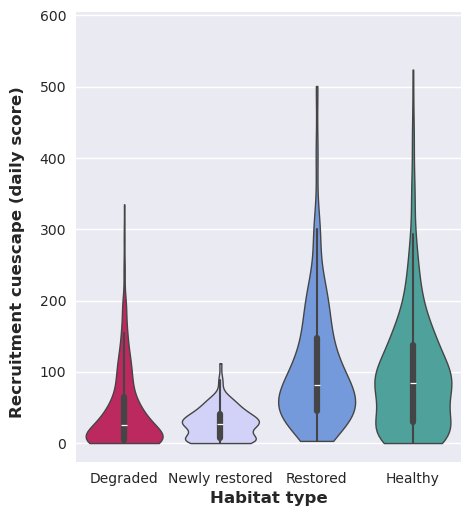

/tmp/ipykernel_14292/1863067255.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_14292/1863067255.py:75: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_14292/1863067255.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([TREATMENT_LABELS[t] for t in TREATMENT_ORDER])


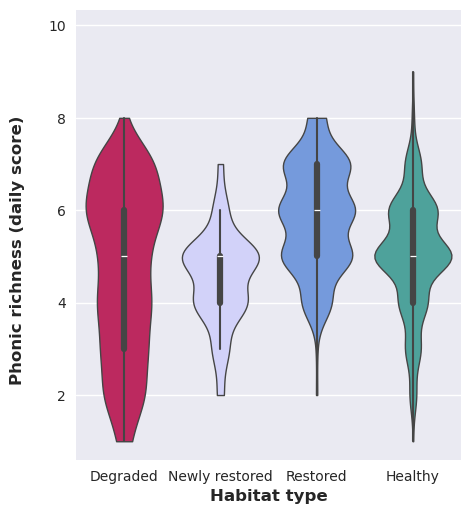

/tmp/ipykernel_14292/1863067255.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_14292/1863067255.py:75: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_14292/1863067255.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([TREATMENT_LABELS[t] for t in TREATMENT_ORDER])


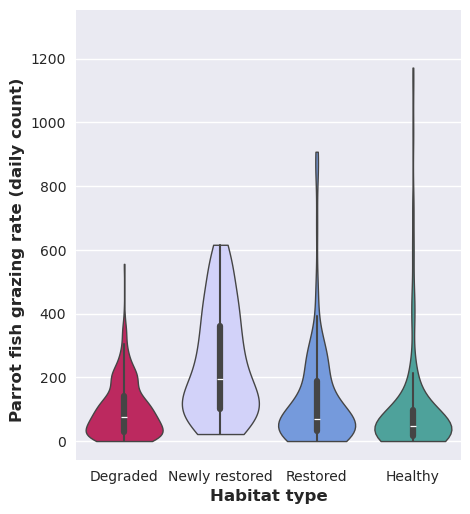

/tmp/ipykernel_14292/1863067255.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_14292/1863067255.py:75: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_14292/1863067255.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([TREATMENT_LABELS[t] for t in TREATMENT_ORDER])


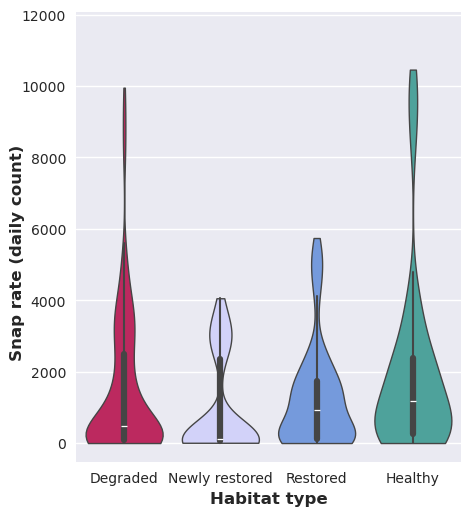

In [ ]:
import os
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

BASE_DIR = os.getenv("BASE_DIR")
if not BASE_DIR:
  raise ValueError("BASE_DIR environment variable is not set.")
csv_dir = os.path.join(BASE_DIR, "marrs_acoustics/data/results/functions")

TREATMENT_INFO = {
  "degraded": {"label": "Degraded", "color": "#D41159"},
  "newly_restored": {"label": "Newly restored", "color": "#CCCCFF"},
  "restored": {"label": "Restored", "color": "#6495ED"},
  "healthy": {"label": "Healthy", "color": "#40B0A6"}
}
TREATMENT_ORDER = list(TREATMENT_INFO.keys())
TREATMENT_LABELS = {k: v["label"] for k, v in TREATMENT_INFO.items()}
TREATMENT_COLORS = {k: v["color"] for k, v in TREATMENT_INFO.items()}

CSV_MAPPING = {
    "settlement_cuescape.csv": {
        "title": "Recruitment cuescape",
        "exclude_outliers": 6,
        "y-axis title": "Recruitment cuescape (daily score)"
    },
    "phonic_richness.csv": {
        "title": "Phonic richness",
        "exclude_outliers": 0,
        "y-axis title": "Phonic richness (daily score)"
    },
    "graze_count.csv": {
        "title": "Parrot fish grazing rate",
        "exclude_outliers": 10,
        "y-axis title": "Parrot fish grazing rate (daily count)"
    },
    "snaps_count.csv": {
        "title": "Snap rate",
        "exclude_outliers": 10,
        "y-axis title": "Snap rate (daily count)"
    }
}

def read_data(csv_path: str) -> pd.DataFrame:
  """Read CSV and set 'treatment' as an ordered categorical."""
  df = pd.read_csv(csv_path)
  df["treatment"] = pd.Categorical(df["treatment"],
                                   categories=TREATMENT_ORDER,
                                   ordered=True)
  return df

def plot_violin(
    df: pd.DataFrame,
    x_col: str,
    y_col: str,
    plot_title: str,
    y_axis_label: str,
    exclude_outliers: int = 0,
    fig_width: float = 6,
    fig_height: float = 4,
    cut_val: float = 1.0
) -> plt.Figure:
  """Plot violin with a fixed grid area and a manually placed y-axis label."""
  if exclude_outliers > 0:
    df = df.drop(df.nlargest(exclude_outliers, y_col).index)

  sns.set_style("darkgrid")

  # Create figure and manually place Axes so the plotting area stays fixed
  fig = plt.figure(figsize=(fig_width, fig_height))
  ax = fig.add_axes([0.2, 0.15, 0.7, 0.75])  # [left, bottom, width, height]

  sns.violinplot(
      data=df,
      x=x_col,
      y=y_col,
      order=TREATMENT_ORDER,
      palette=TREATMENT_COLORS,
      ax=ax,
      cut=cut_val,
      inner="box",
      linewidth=1,
      width=0.8,
      scale="width"
  )

  # Extend y-axis a bit
  y_min, y_max = ax.get_ylim()
  ax.set_ylim(y_min, y_max * 1.1)

  # Set up x-axis
  ax.set_xticklabels([TREATMENT_LABELS[t] for t in TREATMENT_ORDER])
  ax.set_xlabel("Habitat type", fontweight="bold", fontsize=12)

  # Remove default y-axis label to avoid collisions
  ax.set_ylabel("")
  # Manually set where to place the y-axis title using the first param here
  fig.text(0.08, 0.5, y_axis_label, va="center",
           rotation="vertical", fontweight="bold", fontsize=12)

  # Optionally set a title if needed
  # fig.suptitle(plot_title, fontweight="bold", fontsize=10)

  ax.legend([], [], frameon=False)
  return fig

for csv_file, info in CSV_MAPPING.items():
  csv_path = os.path.join(csv_dir, csv_file)
  data_df = read_data(csv_path)

  if csv_file == "graze_count.csv":
    data_df = data_df[data_df["country"].str.lower() != "kenya"]

  fig = plot_violin(
      df=data_df,
      x_col="treatment",
      y_col="count",
      plot_title=info["title"],
      y_axis_label=info["y-axis title"],
      exclude_outliers=info["exclude_outliers"],
      fig_width=5.5,
      fig_height=6,
      cut_val=0
  )
  plt.show()


## By country

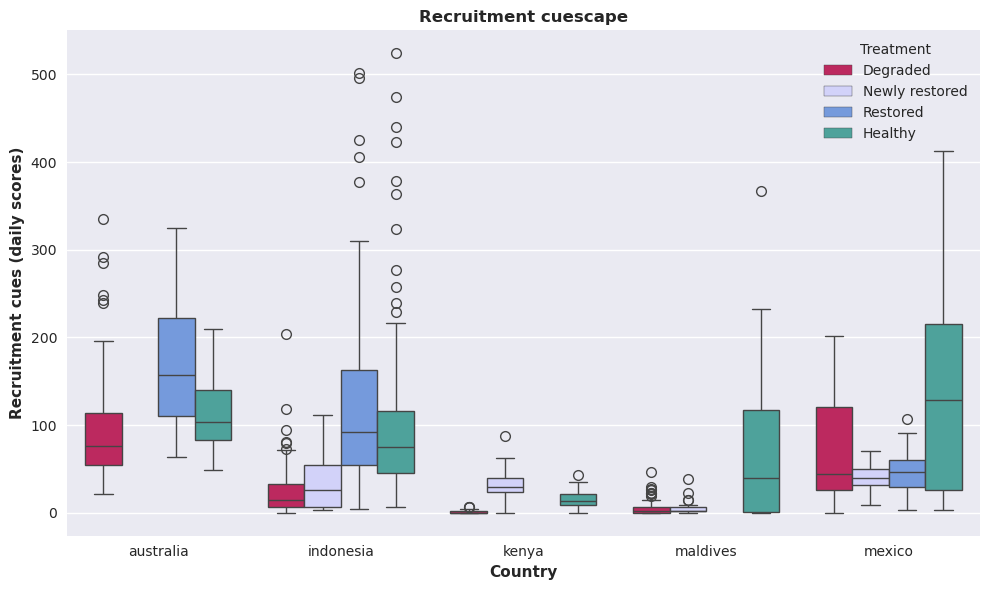

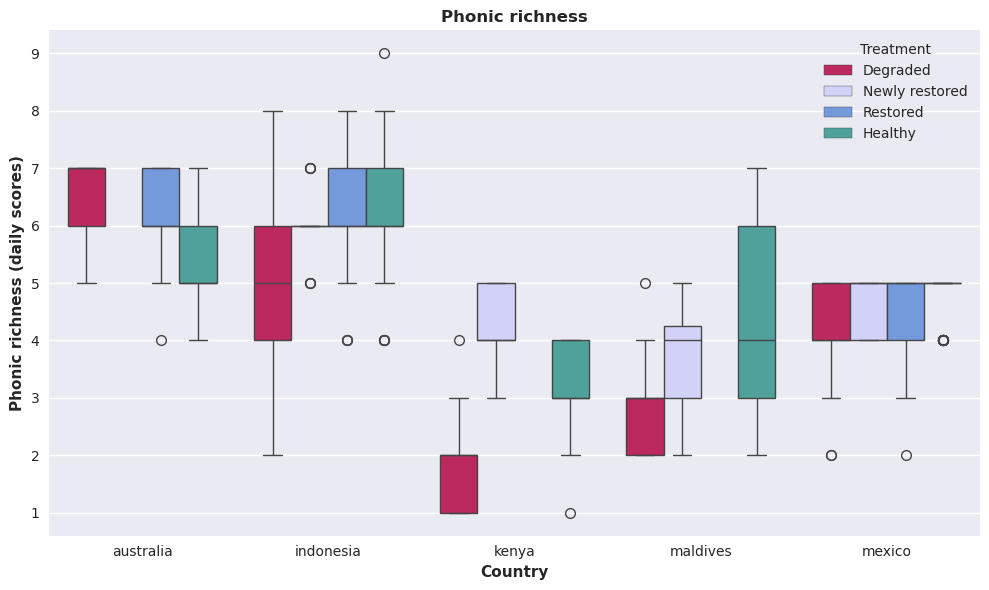

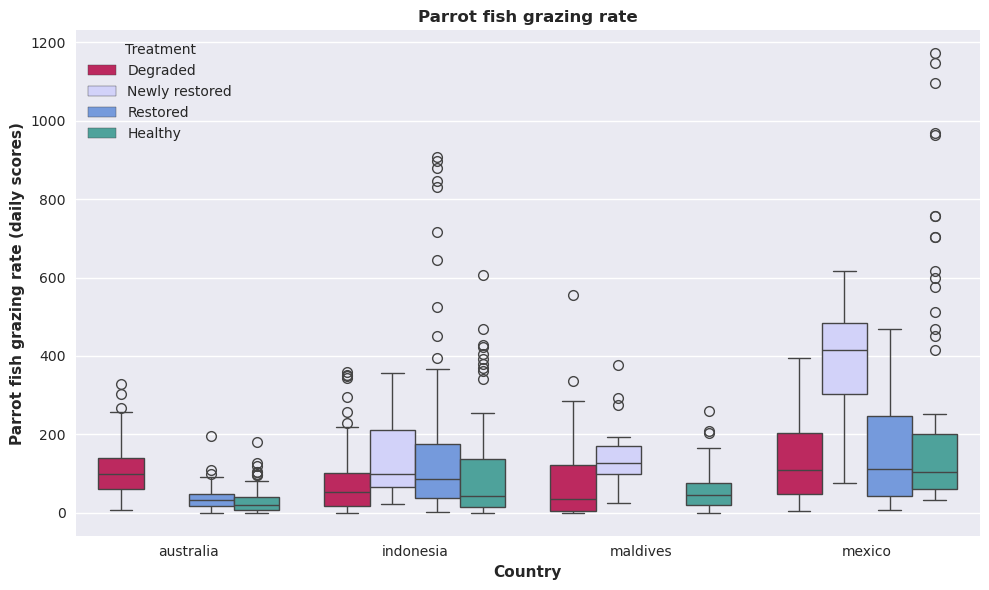

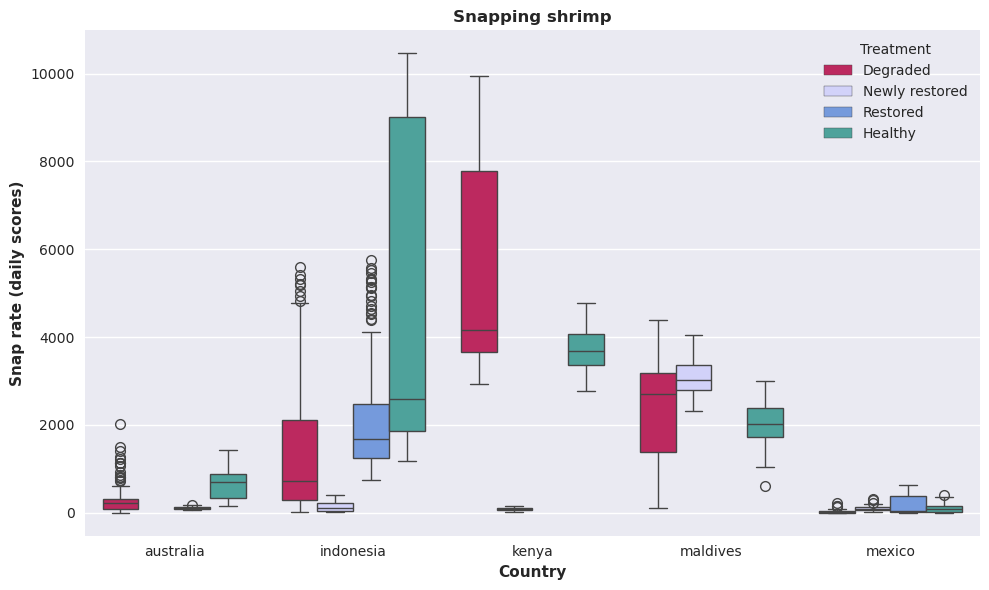

In [10]:
import os
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Get path to folder of csv files
BASE_DIR = os.getenv("BASE_DIR")
if not BASE_DIR:
  raise ValueError("BASE_DIR environment variable is not set.")
csv_dir = os.path.join(BASE_DIR, "marrs_acoustics/data/results/functions")

# Combine treatment order, label, and color in a single dict
TREATMENT_INFO = {
  "degraded": {
      "label": "Degraded",
      "color": "#D41159"
  },
  "newly_restored": {
      "label": "Newly restored",
      "color": "#CCCCFF"
  },
  "restored": {
      "label": "Restored",
      "color": "#6495ED"
  },
  "healthy": {
      "label": "Healthy",
      "color": "#40B0A6"
  }
}

# Extract a list (order) of treatment keys
TREATMENT_ORDER = list(TREATMENT_INFO.keys())

# Build separate dictionaries for labels & colours for Seaborn
TREATMENT_LABELS = {k: v["label"] for k, v in TREATMENT_INFO.items()}
TREATMENT_COLORS = {k: v["color"] for k, v in TREATMENT_INFO.items()}

# CSVs mapping: filename -> config
CSV_MAPPING = {
    "settlement_cuescape.csv": {
        "title": "Recruitment cuescape",
        "exclude_outliers": 6,
        "y-axis title": "Recruitment cues (daily scores)"
    },
    "phonic_richness.csv": {
        "title": "Phonic richness",
        "exclude_outliers": 0,
        "y-axis title": "Phonic richness (daily scores)"
    },
    "graze_count.csv": {
        "title": "Parrot fish grazing rate",
        "exclude_outliers": 10,
        "y-axis title": "Parrot fish grazing rate (daily scores)"
    },
    "snaps_count.csv": {
        "title": "Snapping shrimp",
        "exclude_outliers": 10,
        "y-axis title": "Snap rate (daily scores)"
    }
}

def read_data(csv_path: str) -> pd.DataFrame:
  """Read CSV and set 'treatment' as an ordered categorical."""
  df = pd.read_csv(csv_path)
  df["treatment"] = pd.Categorical(
      df["treatment"],
      categories=TREATMENT_ORDER,
      ordered=True
  )
  return df

def plot_box_by_country(
    df: pd.DataFrame,
    x_col: str,        # "country"
    y_col: str,        # "count"
    hue_col: str,      # "treatment"
    plot_title: str,
    y_axis_label: str,
    exclude_outliers: int = 0,
    fig_width: float = 10,
    fig_height: float = 6,
    whis: float = 1.5
) -> plt.Figure:
  """
  Plot a boxplot grouped by x_col (country),
  separating data by hue_col (treatment).
  'whis' controls how forgiving the boxplot is
  about marking outliers.
  """
  # Exclude top 'exclude_outliers' rows based on y_col
  if exclude_outliers > 0:
    df = df.drop(df.nlargest(exclude_outliers, y_col).index)

  sns.set_style("darkgrid")
  fig, ax = plt.subplots(figsize=(fig_width, fig_height))

  sns.boxplot(
      data=df,
      x=x_col,
      y=y_col,
      hue=hue_col,
      hue_order=TREATMENT_ORDER,
      palette=TREATMENT_COLORS,
      whis=whis,
      dodge=True,
      ax=ax
  )

  ax.set_xlabel("Country", fontweight="bold")
  ax.set_ylabel(y_axis_label, fontweight="bold")
  ax.set_title(plot_title, fontweight="bold")

  # Let Seaborn create a legend for the treatments
  # Map the legend labels to our TREATMENT_LABELS
  handles, labels = ax.get_legend_handles_labels()
  # Replace the raw treatment keys with user-friendly labels
  new_labels = [TREATMENT_LABELS.get(lbl, lbl) for lbl in labels]
  ax.legend(handles, new_labels, title="Treatment")

  plt.tight_layout()
  return fig

# Loop through each CSV, read data, then plot
for csv_file, info in CSV_MAPPING.items():
  csv_path = os.path.join(csv_dir, csv_file)
  data_df = read_data(csv_path)

  # Special case for graze_count.csv: exclude 'kenya'
  if csv_file == "graze_count.csv":
    data_df = data_df[data_df["country"].str.lower() != "kenya"]

  fig = plot_box_by_country(
      df=data_df,
      x_col="country",
      y_col="count",
      hue_col="treatment",
      plot_title=info["title"],
      y_axis_label=info["y-axis title"],
      exclude_outliers=info["exclude_outliers"],
      fig_width=10,
      fig_height=6,
      whis=1.5
  )
  plt.show()


## Trying to fix gap for missing treatments to no avail so far:

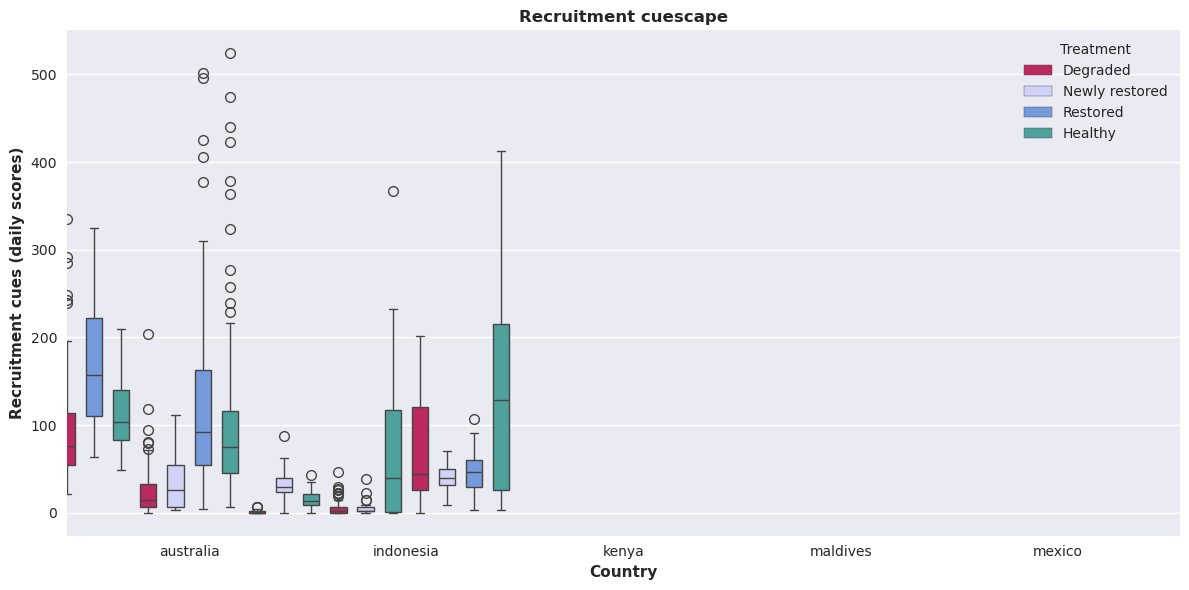

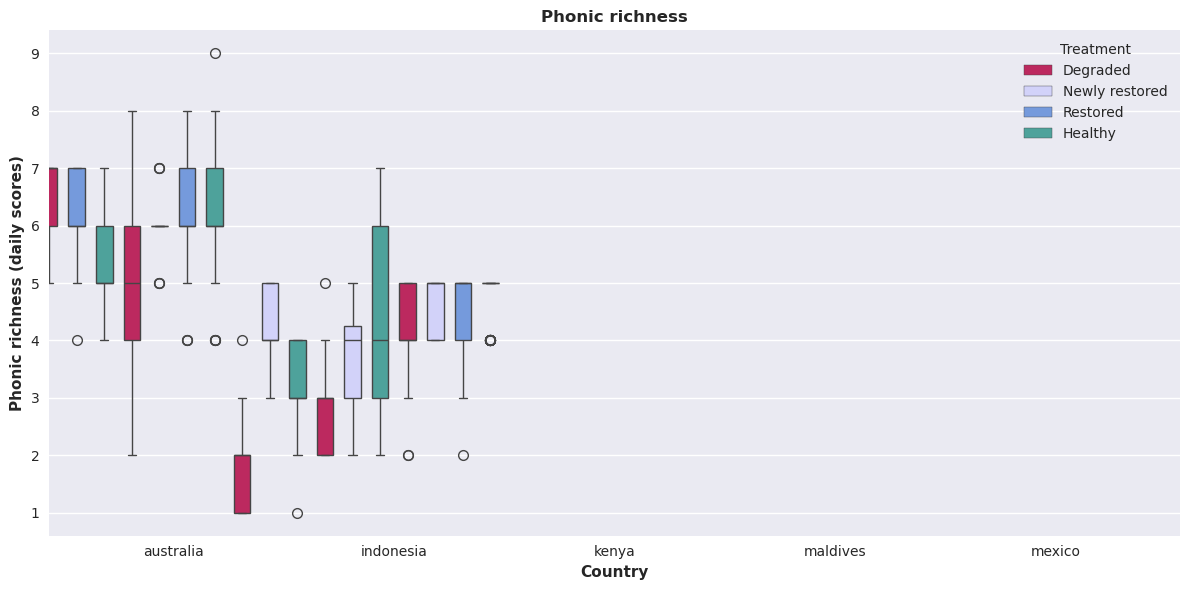

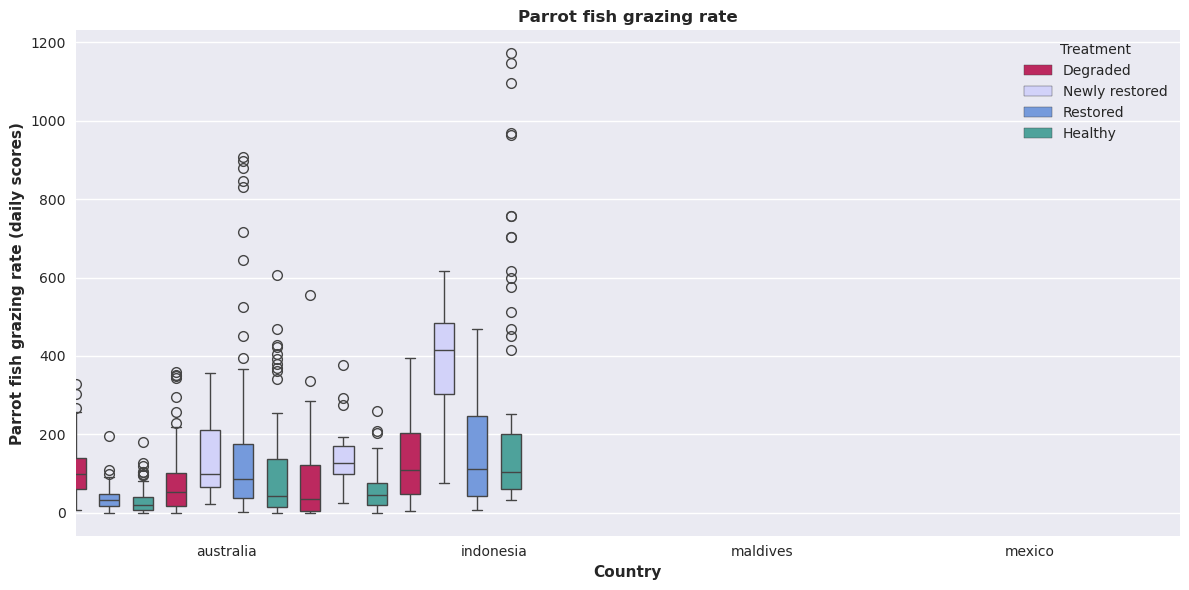

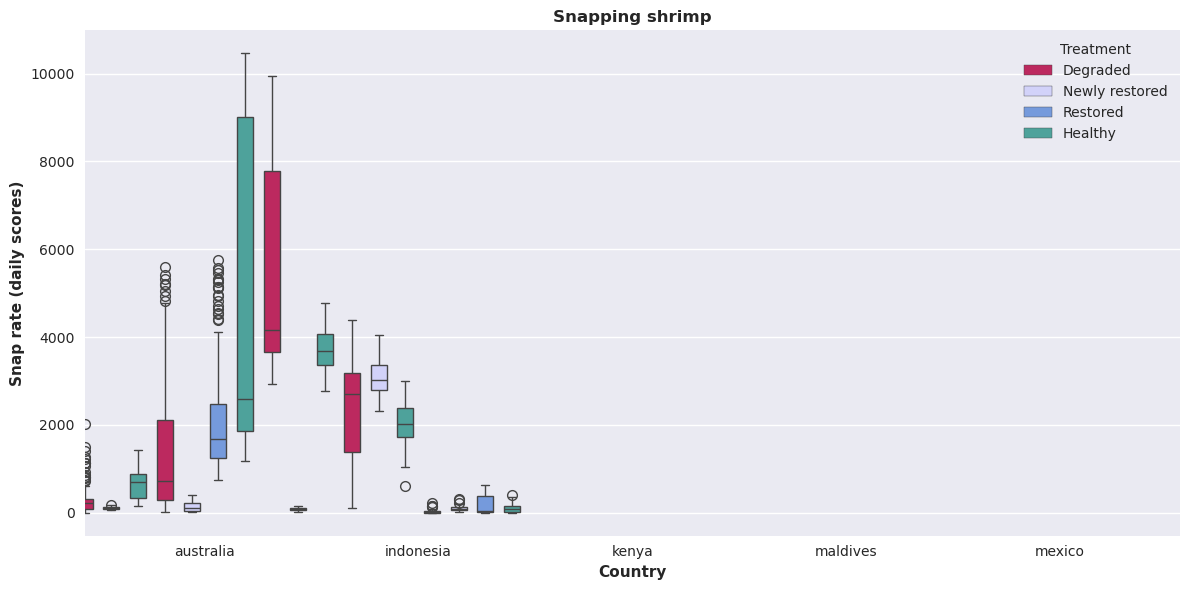

In [11]:
import os
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Get path to folder of csv files
BASE_DIR = os.getenv("BASE_DIR")
if not BASE_DIR:
  raise ValueError("BASE_DIR environment variable is not set.")
csv_dir = os.path.join(BASE_DIR, "marrs_acoustics/data/results/functions")

# Treatment info
TREATMENT_INFO = {
    "degraded": {
        "label": "Degraded",
        "color": "#D41159"
    },
    "newly_restored": {
        "label": "Newly restored",
        "color": "#CCCCFF"
    },
    "restored": {
        "label": "Restored",
        "color": "#6495ED"
    },
    "healthy": {
        "label": "Healthy",
        "color": "#40B0A6"
    }
}
TREATMENT_ORDER = list(TREATMENT_INFO.keys())
TREATMENT_COLORS = [TREATMENT_INFO[t]["color"] for t in TREATMENT_ORDER]

# CSV mapping
CSV_MAPPING = {
    "settlement_cuescape.csv": {
        "title": "Recruitment cuescape",
        "exclude_outliers": 6,
        "y-axis title": "Recruitment cues (daily scores)"
    },
    "phonic_richness.csv": {
        "title": "Phonic richness",
        "exclude_outliers": 0,
        "y-axis title": "Phonic richness (daily scores)"
    },
    "graze_count.csv": {
        "title": "Parrot fish grazing rate",
        "exclude_outliers": 10,
        "y-axis title": "Parrot fish grazing rate (daily scores)"
    },
    "snaps_count.csv": {
        "title": "Snapping shrimp",
        "exclude_outliers": 10,
        "y-axis title": "Snap rate (daily scores)"
    }
}

def read_data(csv_path: str) -> pd.DataFrame:
  """Read CSV, set 'treatment' as an ordered categorical."""
  df = pd.read_csv(csv_path)
  df["treatment"] = pd.Categorical(
      df["treatment"],
      categories=TREATMENT_ORDER,
      ordered=True
  )
  return df

def plot_box_by_country(
    df: pd.DataFrame,
    plot_title: str,
    y_axis_label: str,
    exclude_outliers: int = 0,
    fig_width: float = 12,
    fig_height: float = 6,
    whis: float = 1.5
) -> plt.Figure:
  """
  Each country is allocated a fixed chunk on the x-axis, guaranteeing 
  visible gaps between countries. Inside that chunk, existing treatments 
  are spaced evenly (missing treatments produce no box).
  """

  # ---------------- 1) Outlier removal & re-index ----------------
  if exclude_outliers > 0:
    df = df.drop(df.nlargest(exclude_outliers, "count").index)
  df = df.reset_index(drop=True)

  # Countries in the order they appear
  countries = df["country"].drop_duplicates().tolist()

  # ---------------- 2) Spacing constants ----------------
  chunk_width = 5.0       # width of each country block
  chunk_gap   = 3.0       # horizontal gap between consecutive countries
  left_margin = 2.0       # offset so first chunk is not at x=0
  side_buffer = 0.5       # margin inside the chunk on each side

  # We'll store x_positions for each row
  x_positions = [None]*len(df)

  # ---------------- 3) Assign x_numeric for each country’s treatments ----------------
  for i, country in enumerate(countries):
    # The left edge of this country’s chunk
    chunk_left = left_margin + i*(chunk_width + chunk_gap)
    chunk_right = chunk_left + chunk_width

    # Subset for this country
    df_country = df[df["country"] == country]
    # Which treatments are present?
    present_treats = [t for t in TREATMENT_ORDER if t in df_country["treatment"].values]
    n = len(present_treats)
    if n == 0:
      continue  # skip if no data

    # We define x coordinates for these n treatments inside [chunk_left+side_buffer, chunk_right-side_buffer]
    # If n=1, place at midpoint. If n=2, split in half, etc.
    # So the effective "usable width" = chunk_width - 2*side_buffer
    usable_width = chunk_width - 2*side_buffer
    # We'll place each present treatment i in [0..n-1], evenly spaced
    # normalised x in [0..1], i from 0..(n-1)
    # e.g. if n>1, step=1/(n-1). If n=1 => just place at midpoint
    if n == 1:
      # single treatment => place in the chunk center
      single_x = chunk_left + chunk_width*0.5
      t = present_treats[0]
      mask = (df["country"] == country) & (df["treatment"] == t)
      row_ids = df.index[mask]
      for rid in row_ids:
        x_positions[rid] = single_x
    else:
      # multiple treatments => space them evenly
      step = usable_width / (n - 1)
      for j, t in enumerate(present_treats):
        x_val = chunk_left + side_buffer + j*step
        mask = (df["country"] == country) & (df["treatment"] == t)
        row_ids = df.index[mask]
        for rid in row_ids:
          x_positions[rid] = x_val

  # We can define the final chunk’s right edge to set x-limits
  last_chunk_index = len(countries) - 1
  last_chunk_left = left_margin + last_chunk_index*(chunk_width + chunk_gap)
  x_max = last_chunk_left + chunk_width + 2.0  # some margin

  # ---------------- 4) Attach x_numeric, do a single boxplot call with hue ----------------
  df = df.copy()
  df["x_numeric"] = x_positions
  # Sort so we plot left->right
  df = df.sort_values("x_numeric").reset_index(drop=True)

  sns.set_style("darkgrid")
  fig, ax = plt.subplots(figsize=(fig_width, fig_height))

  sns.boxplot(
      data=df,
      x="x_numeric",
      y="count",
      hue="treatment",
      hue_order=TREATMENT_ORDER,
      palette=TREATMENT_COLORS,
      whis=whis,
      dodge=False,
      width=0.6,  # narrower boxes so there's room
      ax=ax
  )

  # ---------------- 5) Build x-ticks at the midpoint of each chunk ----------------
  xticks = []
  xlabels = []

  for i, country in enumerate(countries):
    # chunk center = chunk_left + chunk_width/2
    chunk_left = left_margin + i*(chunk_width + chunk_gap)
    mid = chunk_left + chunk_width/2
    xticks.append(mid)
    xlabels.append(country)

  ax.set_xticks(xticks)
  ax.set_xticklabels(xlabels, fontweight=None)  # normal weight, not bold

  ax.set_xlim(0, x_max)  # give margin on the right

  # Axis labels
  ax.set_xlabel("Country", fontweight="bold")
  ax.set_ylabel(y_axis_label, fontweight="bold")
  ax.set_title(plot_title, fontweight="bold")

  # Legend: map raw treatment keys to friendly labels
  handles, labels = ax.get_legend_handles_labels()
  label_map = {k: v["label"] for k, v in TREATMENT_INFO.items()}
  new_labels = [label_map.get(l, l) for l in labels]
  ax.legend(handles, new_labels, title="Treatment", loc="best")

  plt.tight_layout()
  return fig

# ------------------- MAIN SCRIPT -------------------
if __name__ == "__main__":
  for csv_file, info in CSV_MAPPING.items():
    csv_path = os.path.join(csv_dir, csv_file)
    data_df = read_data(csv_path)

    # e.g. exclude 'kenya' for graze_count
    if csv_file == "graze_count.csv":
      data_df = data_df[data_df["country"].str.lower() != "kenya"]

    fig = plot_box_by_country(
        df=data_df,
        plot_title=info["title"],
        y_axis_label=info["y-axis title"],
        exclude_outliers=info["exclude_outliers"],
        fig_width=12,
        fig_height=6,
        whis=1.5
    )
    plt.show()






## Effects plots

In [3]:
BASE_DIR

'/home/bwilliams/ucl_projects/'

INFO:root:Loading data
INFO:root:Filtering data
INFO:root:Plotting data


   eco_function      model_name           scale                     term  \
46  graze_count  STANDARD_MODEL  Original-Scale  treatmentnewly_restored   
47  graze_count  STANDARD_MODEL  Original-Scale        treatmentrestored   
89  snaps_count  STANDARD_MODEL  Original-Scale         treatmenthealthy   
90  snaps_count  STANDARD_MODEL  Original-Scale  treatmentnewly_restored   
91  snaps_count  STANDARD_MODEL  Original-Scale        treatmentrestored   

    Estimate  Lower_95  Upper_95  Lower_75  Upper_75   p_value  
46  2.584545  0.831893  8.029719  1.328715  5.027316  0.100643  
47  1.468561  0.581589  3.708236  0.852682  2.529280  0.416144  
89  2.610416  1.092688  6.236248  1.565767  4.352034  0.030815  
90  0.284026  0.087095  0.926244  0.141922  0.568415  0.036888  
91  1.693096  0.587968  4.875388  0.910105  3.149719  0.329168  
['settlement_cuescape' 'phonic_richness' 'graze_count' 'snaps_count']


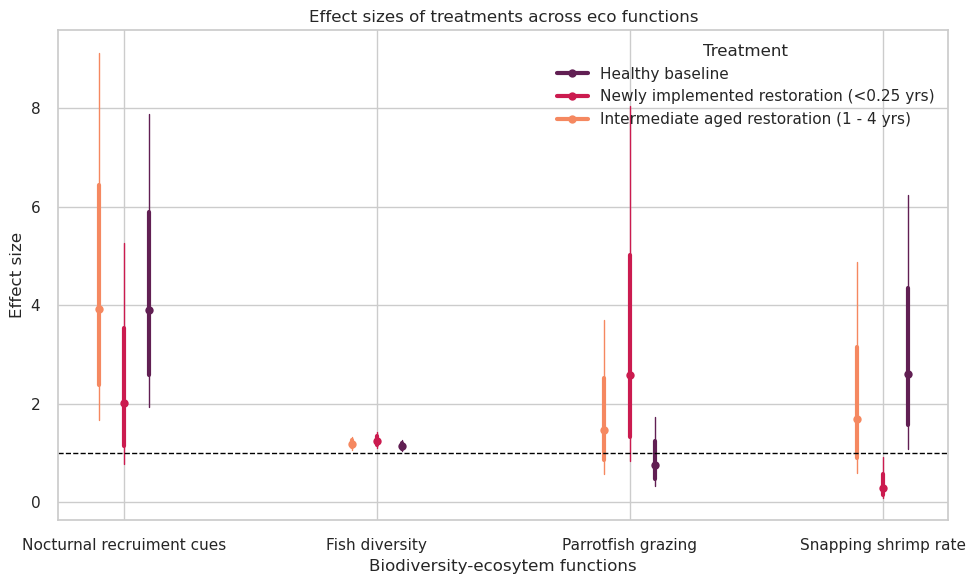

In [25]:
"""Plot effect sizes for treatments across biodiversity-ecosystem functions."""

import logging
from typing import Dict, List

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Global constants
CSV_PATH = BASE_DIR + "marrs_acoustics/data/results/functions/stats/summary_outputs/combined_results.csv"
MODEL_GROUP = "STANDARD_MODEL"
SCALE = "Original-Scale"
DESIRED_TERMS = {"treatmenthealthy", "treatmentnewly_restored", "treatmentrestored"}
# Mapping of eco functions to x-axis labels
ECO_MAPPING: Dict[str, str] = {
    "settlement_cuescape": "Nocturnal recruiment cues",
    "phonic_richness": "Fish diversity",
    "graze_count": "Parrotfish grazing",
    "snaps_count": "Snapping shrimp rate",
}
# Mapping of treatment terms to legend labels
TREATMENT_MAPPING: Dict[str, str] = {
    "treatmenthealthy": "Healthy baseline",
    "treatmentnewly_restored": "Newly implemented restoration (<0.25 yrs)",
    "treatmentrestored": "Intermediate aged restoration (1 - 4 yrs)",
}
# Order of treatments and associated x-offsets for grouping
TREATMENT_ORDER: List[str] = ["treatmenthealthy", "treatmentnewly_restored", "treatmentrestored"]
OFFSET_MAPPING: Dict[str, float] = {
    "treatmenthealthy": 0.1,
    "treatmentnewly_restored": 0.0,
    "treatmentrestored": -0.1,
}

logging.basicConfig(level=logging.INFO)


def load_data(csv_path: str) -> pd.DataFrame:
  """Load CSV data into a DataFrame."""
  df = pd.read_csv(csv_path)
  # change NA to None
  df = df.where(pd.notnull(df), None)
  return df


def filter_data(df: pd.DataFrame) -> pd.DataFrame:
  """Filter for desired model group, scale and treatment terms."""
  df = df[
      (df["model_name"] == MODEL_GROUP)
      & (df["scale"] == SCALE)
      & (df["term"].isin(DESIRED_TERMS))
  ]
  # Check all eco fucntions present
  print(df.tail())
  print(df["eco_function"].unique())
  return df


def plot_effects(df: pd.DataFrame) -> None:
  """Create a plot of effect sizes with confidence intervals per treatment."""
  # Only use eco functions that are in our mapping (preserves desired order)
  ordered_ecos = [eco for eco in ECO_MAPPING if eco in df["eco_function"].unique()]
  x_mapping = {eco: i for i, eco in enumerate(ordered_ecos)}

  sns.set_theme(style="whitegrid")
  fig, ax = plt.subplots(figsize=(10, 6))

  # Get colours from the seaborn "rocket" palette
  palette = sns.color_palette("rocket", n_colors=len(TREATMENT_ORDER))
  color_mapping = {t: palette[i] for i, t in enumerate(TREATMENT_ORDER)}

  # Plot each treatment line for each eco function
  for _, row in df.iterrows():
    eco = row["eco_function"]
    treatment = row["term"]
    if eco not in x_mapping:
      continue  # Skip if eco function is not in the mapping
    x_base = x_mapping[eco]
    x = x_base + OFFSET_MAPPING[treatment]
    # Plot full (95%) CI as a thin line
    ax.plot([x, x], [row["Lower_95"], row["Upper_95"]], color=color_mapping[treatment], lw=1)
    # Plot inner (75%) CI as a thicker line
    ax.plot([x, x], [row["Lower_75"], row["Upper_75"]], color=color_mapping[treatment], lw=3)
    # Plot a circular marker at the Estimate
    ax.plot(x, row["Estimate"], "o", color=color_mapping[treatment], markersize=6)

  # Add dashed horizontal line at y=1
  ax.axhline(1, ls="--", color="black", lw=1)

  # Set x-axis ticks and labels
  ax.set_xticks([x_mapping[eco] for eco in ordered_ecos])
  ax.set_xticklabels([ECO_MAPPING[eco] for eco in ordered_ecos])
  ax.set_xlabel("Biodiversity-ecosytem functions")
  ax.set_ylabel("Effect size")
  ax.set_title("Effect sizes of treatments across eco functions")

  # Create custom legend handles for treatments
  legend_handles = [
      mlines.Line2D([], [], color=color_mapping[t], marker="o", markersize=6, lw=3, label=TREATMENT_MAPPING[t])
      for t in TREATMENT_ORDER
  ]
  ax.legend(handles=legend_handles, title="Treatment")

  plt.tight_layout()
  plt.show()


# Execution 
logging.info("Loading data")
df = load_data(CSV_PATH)
logging.info("Filtering data")
df_filtered = filter_data(df)
logging.info("Plotting data")
plot_effects(df_filtered)